In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tuning Vertex AI GenAI foundation model



### Based on following sources:
1. https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/tuning/tuning_text_bison.ipynb

### Objective of this notebook

In this notebook, we will tune an existing foundational model available in Vertex AI Model Garden(Text-Bison model) on StackOverflow data available on BigQuery Public Datasets, limiting to questions with the `python` tag, and accepted answers for answers since 2020-01-01.

Steps we will follow to tune the model:

- Load training dataset from BigQuery and generate a JSONL file
- Upload training data
- Create a tuning job
- Inspect your model on Vertex AI Model Registry
- Get predictions from your tuned model

### Install Required libraries

In [ ]:
!pip install google-cloud-aiplatform google-cloud-bigquery sequence-evaluate sentence-transformers rouge --upgrade --user

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
#from google.colab import auth
#auth.authenticate_user()

### BigQuery IAM
Now you need to add permissions to the service account:
- Go to the [IAM page](https://console.cloud.google.com/iam-admin/) in the console
- Look for the default compute service account. It should look something like this: `<project-number>-compute@developer.gserviceaccount.com`
- Assign the default compute service account with `bigquery.user`

### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`. Otherwise, check the support page: Locate the [project ID](https://support.google.com/googleapi/answer/7014113). Please update `PROJECT_ID` below.

In [1]:
PROJECT_ID = "jsb-alto"  #Replace with your Project name

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


### Create a bucket
Now you have to create a bucket that we will use to store our tuning data. To avoid name collisions between users on resources created, you generate a UUID for each instance session and append it to the name of the resources you create in this tutorial.

In [2]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

Choose a bucket name and update the `BUCKET_NAME` parameter.

In [6]:
BUCKET_NAME = "<your_bucket_name>"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"
REGION = "us-central1"  # @param {type: "string"}

In [9]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "<your_bucket_name>":
    BUCKET_NAME = "vertex-" + UUID
    BUCKET_URI = f"gs://{BUCKET_NAME}"

Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.

In [10]:
!gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

Creating gs://vertex-i7urnuhj/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [11]:
!gsutil ls -al $BUCKET_URI

### Import libraries

**Colab only**: Uncomment the following cell to initialize the Vertex AI SDK. For Vertex AI Workbench, you don't need to run this.

In [12]:
import vertexai

vertexai.init(project=PROJECT_ID, location=REGION)

In [13]:
from typing import Union

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

from vertexai.preview.language_models import TextGenerationModel
from google.cloud import aiplatform
from google.cloud import bigquery

## Tune your Model

Now it's time for you to create a tuning job. Tune a foundation model by creating a pipeline job using Generative AI Studio, cURL, or the Python SDK. In this notebook, we will be using the Python SDK. 

### Training Data
💾 Your model tuning dataset must be in a JSONL format where each line contains a single training example. You must make sure that you include instructions.

You will use the StackOverflow data on BigQuery Public Datasets, limiting to questions with the `python` tag, and accepted answers for answers since 2020-01-01.

First create a helper function to let you easily query BigQuery and return the results as a Pandas DataFrame.

In [14]:
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:
    """
    Run a BigQuery query and return the job ID or result as a DataFrame
    Args:
        sql: SQL query, as a string, to execute in BigQuery
    Returns:
        df: DataFrame of results from query,  or error, if any
    """

    bq_client = bigquery.Client(project=PROJECT_ID)

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")

    return df

Next define the query.

In [15]:
df = run_bq_query(
    """SELECT
    CONCAT(q.title, q.body) as input_text,
    a.body AS output_text
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
JOIN
    `bigquery-public-data.stackoverflow.posts_answers` a
ON
    q.accepted_answer_id = a.id
WHERE
    q.accepted_answer_id IS NOT NULL AND
    REGEXP_CONTAINS(q.tags, "python") AND
    a.creation_date >= "2020-01-01"
LIMIT
    10000
"""
)

df.head()

Finished job_id: 9a10ae71-9d47-4b94-af3b-b2653124181f


,input_text,output_text
0,Sort top N maximum absolute values of a column...,<p>Try with <code>head</code></p>\n<pre><code>...
1,"Pandas group by x, sort by y, select z, aggreg...",<p>Maybe something like this?</p>\n<pre><code>...
2,Create a column that contains the sum of rows ...,<p>You can try <code>groupby.transform</code> ...
3,Iterate over multiple columns and replace the ...,"<pre><code>df.iloc[:, :2].join(df.iloc[:, 2:]...."
4,Python. Merge multiple Excel files and add a c...,<p>In the for loop you should change</p>\n<pre...


### Split data into training and test sets

In [19]:
# split is set to 80/20
train, evaluation = train_test_split(df, test_size=0.2)
evaluation = evaluation.sample(n=250, random_state=1)
print(len(train))
print(len(evaluation))

8000
250


For tuning, the training data first needs to be converted into a JSONL format.

In [20]:
tune_jsonl = train.to_json(orient="records", lines=True)

print(f"Length: {len(tune_jsonl)}")
print(tune_jsonl[0:100])

Length: 23639738
{"input_text":"I cant create a page with an empty path in Django<p>centralsite\/views<\/p>\n<pre><co


Next, you can write it to a local JSONL before transferring it to Google Cloud Storage (GCS).

In [21]:
training_data_filename = "tune_data_stack_overflow_python_qa.jsonl"

with open(training_data_filename, "w") as f:
    f.write(tune_jsonl)

In [22]:
tune_jsonl = evaluation.to_json(orient="records", lines=True)

print(f"Length: {len(tune_jsonl)}")
print(tune_jsonl[0:100])

Length: 775955
{"input_text":"Python difflib gives bad results<p>I'm using the python <code>difflib<\/code> to calc


In [23]:
evaluation_data_filename = "tune_eval_data_stack_overflow_python_qa.jsonl"

with open(evaluation_data_filename, "w") as f:
    f.write(tune_jsonl)

You can then export the local file to GCS, so that it can be used by Vertex AI for the tuning job.

In [24]:
! gsutil cp $training_data_filename $evaluation_data_filename $BUCKET_URI

Copying file://tune_data_stack_overflow_python_qa.jsonl [Content-Type=application/octet-stream]...
Copying file://tune_eval_data_stack_overflow_python_qa.jsonl [Content-Type=application/octet-stream]...
/ [2 files][ 23.3 MiB/ 23.3 MiB]                                                
Operation completed over 2 objects/23.3 MiB.                                     


You can check to make sure that the file successfully transferred to your Google Cloud Storage bucket:

In [25]:
! gsutil ls -al $BUCKET_URI

  23639738  2023-11-27T01:28:17Z  gs://vertex-i7urnuhj/tune_data_stack_overflow_python_qa.jsonl#1701048497686307  metageneration=1
    775955  2023-11-27T01:28:17Z  gs://vertex-i7urnuhj/tune_eval_data_stack_overflow_python_qa.jsonl#1701048497796835  metageneration=1
TOTAL: 2 objects, 24415693 bytes (23.28 MiB)


In [26]:
TRAINING_DATA_URI = f"{BUCKET_URI}/{training_data_filename}"
EVAUATION_DATA_URI = f"{BUCKET_URI}/{evaluation_data_filename}"

### Model Tuning
Now it's time to start to tune a model. You will use the Vertex AI SDK to submit our tuning job.

#### Recommended Tuning Configurations
✅ Here are some recommended configurations for tuning a foundation model based on the task, in this example Q&A. You can find more in the [documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-models).

Extractive QA:
- Make sure that your train dataset size is 100+
- Training steps [100-500]. You can try more than one value to get the best performance on a particular dataset (e.g. 100, 200, 500)

In [27]:
#create tensorboard
display_name = 'Adapter tuning - '

tensorboard = aiplatform.Tensorboard.create(
       display_name=display_name,
       project=PROJECT_ID,
       location=REGION,
)

print(tensorboard.display_name)
print(tensorboard.resource_name)

Creating Tensorboard
Create Tensorboard backing LRO: projects/398507275014/locations/us-central1/tensorboards/2583522471785267200/operations/3669863530808475648
Tensorboard created. Resource name: projects/398507275014/locations/us-central1/tensorboards/2583522471785267200
To use this Tensorboard in another session:
tb = aiplatform.Tensorboard('projects/398507275014/locations/us-central1/tensorboards/2583522471785267200')
Adapter tuning - 
projects/398507275014/locations/us-central1/tensorboards/2583522471785267200


In [28]:
# Get tensorboard_id thats used in the pipeline
tensorboard_id = tensorboard.resource_name.split('tensorboards/')[-1]
print(tensorboard_id)

2583522471785267200


In [29]:
MODEL_NAME = f"genai-workshop-tuned-model-{UUID}"
TRAINING_STEPS = 100

## Configure tuning pipeline


We will use a pre-built kubeflow tuning pipeline and pass key parameters like reference foundational mode, model-name for our new tuned model, training data stc.



In [44]:
pipeline_arguments = {
    "model_display_name": MODEL_NAME,
    "location": REGION,
    "large_model_reference": "text-bison@001",
    "project": PROJECT_ID,
    "train_steps": TRAINING_STEPS,
    "dataset_uri": TRAINING_DATA_URI,
    "evaluation_interval": 20,
    "evaluation_data_uri": EVAUATION_DATA_URI,
    "tensorboard_resource_id": tensorboard_id,
}

pipeline_root = f'{BUCKET_URI}/{MODEL_NAME}'

#Provide path to the pre-built pipeline
template_path = 'https://us-kfp.pkg.dev/ml-pipeline/large-language-model-pipelines/tune-large-model/v2.0.0'

#### Pipeline steps

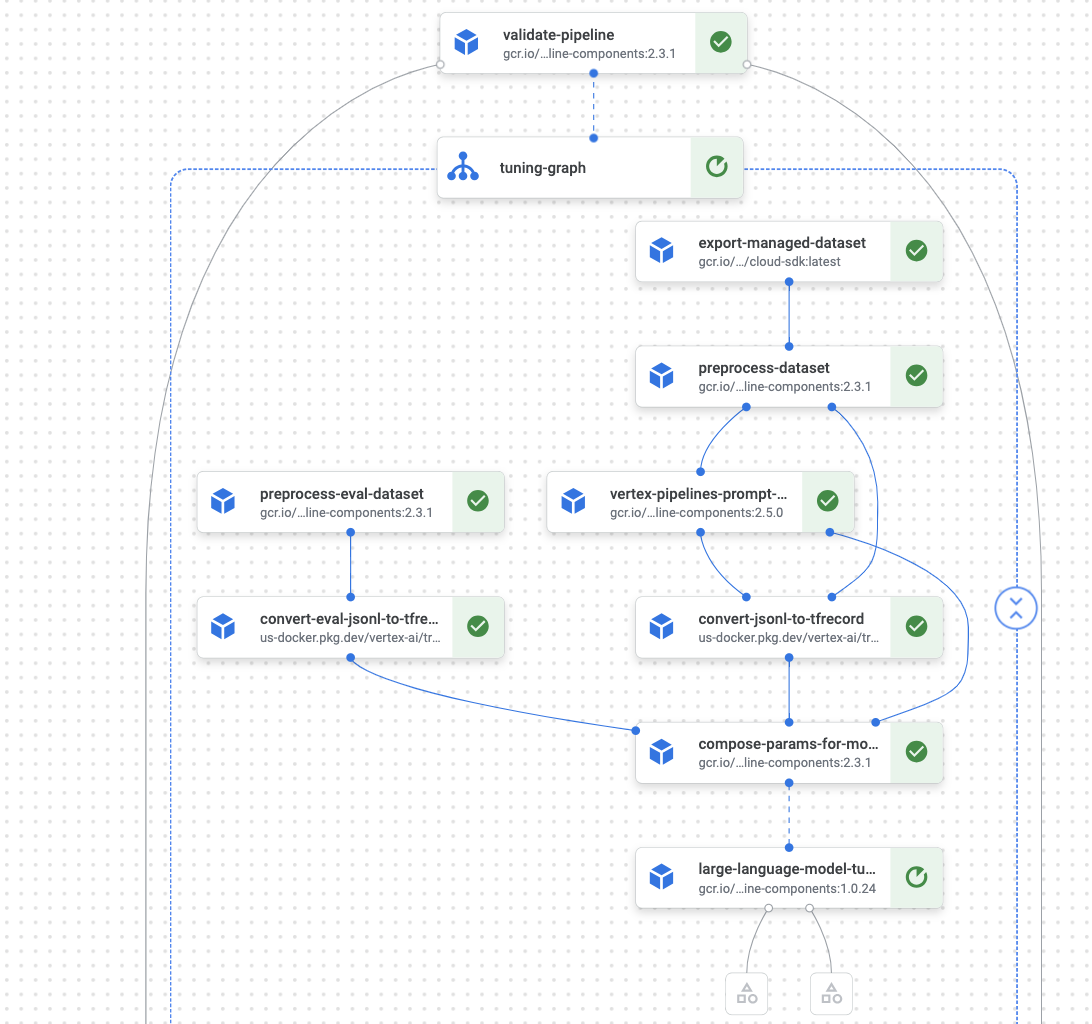

In [45]:
# Function that starts the tuning job
def tuned_model(
    project_id: str,
    location: str,
    template_path: str,
    model_display_name: str,
    pipeline_arguments: str,
):
    """Prompt-tune a new model, based on a prompt-response data.

    "training_data" can be either the GCS URI of a file formatted in JSONL format
    (for example: training_data=f'gs://{bucket}/{filename}.jsonl'), or a pandas
    DataFrame. Each training example should be JSONL record with two keys, for
    example:
      {
        "input_text": <input prompt>,
        "output_text": <associated output>
      },

    Args:
      project_id: GCP Project ID, used to initialize aiplatform
      location: GCP Region, used to initialize aiplatform
      template_path: path to the template
      model_display_name: Name for your model.
      pipeline_arguments: arguments used during pipeline runtime
    """

    aiplatform.init(project=project_id, location=location)

    from google.cloud.aiplatform import PipelineJob

    job = PipelineJob(
        template_path=template_path,
        display_name=model_display_name,
        parameter_values=pipeline_arguments,
        location=REGION,
        pipeline_root=pipeline_root,
        enable_caching=True,
    )

    return job


Next it's time to start your tuning job. **Disclaimer:** tuning and deploying a model takes time.

In [46]:
job = tuned_model(PROJECT_ID, REGION, template_path, MODEL_NAME, pipeline_arguments)

In [ ]:
job.submit()

Following the link above, you can view your pipeline run. As you can see in the screenshot below, it will execute the following steps:

- Validation
- Export managed dataset
- Convert JSONL to TFRecord
- Large language model tuning
- Upload LLM Model

`job.state` lets you check the state of your pipeline.

In [49]:
job.state

RuntimeError: PipelineJob resource has not been created.

## View your tuned foundational model on Vertex AI Model registry
When your tuning job is finished, your model will be available on Vertex AI Model Registry. The following Python SDK sample shows you how to list tuned models.

In [50]:
def list_tuned_models(project_id, location):
    aiplatform.init(project=project_id, location=location)
    model = TextGenerationModel.from_pretrained("text-bison@001")
    tuned_model_names = model.list_tuned_model_names()
    print(tuned_model_names)

In [51]:
list_tuned_models(PROJECT_ID, REGION)

['projects/398507275014/locations/us-central1/models/1215002130134335488']


You can also use the Google Cloud Console UI to view all of your model in [Vertex AI Model Registry](https://console.cloud.google.com/vertex-ai/models?e=13802955&jsmode=O&mods=-ai_platform_fake_service&project=cloud-llm-preview1). Below you can see an example of a tuned foundational model available on Vertex AI Model Registry.

## Use your tuned model to get predictions
Now it's time to get predictions. First you need to get the latest tuned model from the Vertex AI Model registry.

In [52]:
def fetch_model(project_id, location):
    aiplatform.init(project=project_id, location=location)
    model = TextGenerationModel.from_pretrained("text-bison@001")
    list_tuned_models = model.list_tuned_model_names()
    tuned_model = list_tuned_models[0]

    return tuned_model

In [53]:
deployed_model = fetch_model(PROJECT_ID, REGION)
deployed_model = TextGenerationModel.get_tuned_model(deployed_model)

Now you can start send a prompt to the API. Feel free to update the following prompt.

In [54]:
PROMPT = """
How can I store my TensorFlow checkpoint on Google Cloud Storage?

Python example:

"""

In [58]:
generated_code = deployed_model.predict(PROMPT)

In [60]:
print(generated_code.text)

```python
import tensorflow as tf

# Create a checkpoint directory.
checkpoint_dir = "/tmp/my_checkpoints"

# Create a checkpoint file.
checkpoint_file = os.path.join(checkpoint_dir, "my_checkpoint.ckpt")

# Create a saver object.
saver = tf.train.Saver()

# Save the checkpoint.
saver.save(sess, checkpoint_file)

# Load the checkpoint.
saver.restore(sess, checkpoint_file)
```
